In [ ]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, #The inception V3 has a fully-connected layer at the top. So by setting include_top to false, you're specifying that you want to ignore this and get straight to the convolutions.  
                                weights = None)#don't want to use built in weights
pre_trained_model.load_weights(local_weights_file)

#iterate through Pre-Train model layers and lock them, saying that they're not going to be trainable with this code. 
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

--2020-09-01 20:06:29--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 108.177.11.128, 108.177.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  77.6MB/s    in 1.1s    

2020-09-01 20:06:30 (77.6 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0               

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation = 'relu')(x)
'''
The idea behind Dropouts is that they remove a random number of neurons in your neural network. 
This works very well for two reasons: The first is that neighbouring neurons often end up with similar weights, which can lead to over fitting, so dropping some out at random can remove this. 
The second is that often a neuron can over-weigh the input from a neuron in the previous layer, and can over specialise as a result. 
Thus, dropping out can break the neural network out of this potential bad habit!
So how do we achieve this in code? Well, here's our model definition from earlier. 
And here's where we add the dropout. The parameter is between 0 and 1 and it's the fraction of units to drop.
In this case, we're dropping out 20% of our neurons.
'''
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)


--2020-09-01 20:06:34--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 142.250.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   131MB/s    in 0.5s    

2020-09-01 20:06:35 (131 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generatormb
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100,
    epochs = 10,
    validation_steps = 50,
    verbose = 2
)

Epoch 1/10
100/100 - 148s - loss: 0.1356 - acc: 0.9450 - val_loss: 0.1052 - val_acc: 0.9690
Epoch 2/10
100/100 - 157s - loss: 0.1299 - acc: 0.9480 - val_loss: 0.1142 - val_acc: 0.9670
Epoch 3/10
100/100 - 152s - loss: 0.1324 - acc: 0.9525 - val_loss: 0.1202 - val_acc: 0.9660
Epoch 4/10
100/100 - 151s - loss: 0.1181 - acc: 0.9545 - val_loss: 0.1217 - val_acc: 0.9680
Epoch 5/10
100/100 - 151s - loss: 0.1130 - acc: 0.9595 - val_loss: 0.1256 - val_acc: 0.9690
Epoch 6/10
100/100 - 156s - loss: 0.1224 - acc: 0.9525 - val_loss: 0.1220 - val_acc: 0.9630
Epoch 7/10
100/100 - 149s - loss: 0.1212 - acc: 0.9585 - val_loss: 0.1316 - val_acc: 0.9650
Epoch 8/10
100/100 - 149s - loss: 0.1268 - acc: 0.9585 - val_loss: 0.1333 - val_acc: 0.9670
Epoch 9/10
100/100 - 149s - loss: 0.1266 - acc: 0.9565 - val_loss: 0.1080 - val_acc: 0.9720
Epoch 10/10
100/100 - 153s - loss: 0.0997 - acc: 0.9660 - val_loss: 0.1260 - val_acc: 0.9700


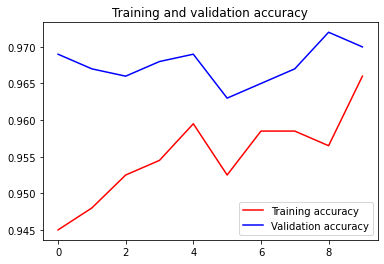

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

#Exercise 3 - Horses vs. humans using Transfer Learning
This week your exercise will be to apply what you've learned about Transfer Learning to see if you can increase training accuracy for Horses v Humans. To avoid crazy overfitting, your validation set accuracy should be around 95% if you do it right!

Your training should automatically stop once it reaches this desired accuracy.

Let's now use Transfer Learning to increase the training accuracy for Horses v Humans!